Caution; This version is actually behind the one in dpj!

Ok so this here sheet is going to be the full image subtraction routine for SN photometry. Note that it is being written to be applied to a single filter at a time, for simplicity!

Note that following the original script from GROWTH 2020, this script will remove the processed directories when you run it, so careful!

This version does not require any alginment beforehand, but should be plate-solved (not entirely sure AIJ routine is good enough, might need to write another to handle that - there is one in the rotation sheet). **Without the plate solve, this script will throw you strange errors!**

The source directory should contain just the source images, and the configuration directory has a bunch of configuration files that this script needs. The data directory will be created by this code as the sources images + conifguration files, and the processed directory will be....the processed directory! This is awkward, but can't really figure out how to make it work otherwise...the out directory contains some random files that are produced in the process, as well as the final difference images.

Note you will have to move the processed files out of the processed/out/ directory into long-term storage of some kind.

This version removes a zeroed, normalized section from each reference image.

In [1]:
# some parameters first.

# Images will be resampled to this size (might have x,y switched!)
SWARPSIZEX=1800
SWARPSIZEY=900


bg_size=50 # for smoothing the background estimator (default 50)
filter_size=3 # size for median filter of background estimator (default 3)

# source position (needed for the windowed subtraction scheme)
RA=128.249
Dec=-27.449311
window=50 # size of windowed region (50 default)

First import relevant packages:

In [2]:
import os  #Call commands from outside Python
import numpy as np

# Running external programs
import subprocess
import shutil

from astropy.coordinates import SkyCoord # For the catalog analysis during normalization

from astropy.io import fits #FITS files handling
from astropy.io import ascii  #Read/write ascii files
from astropy.wcs import WCS # for the cropping routine


# Background subtraction
import photutils
#from photutils.detection import DAOStarFinder
from photutils.segmentation import detect_threshold, detect_sources
#from photutils import Background2D, MedianBackground # old version
from photutils.background import Background2D, MedianBackground 
from astropy.stats import sigma_clipped_stats, SigmaClip # statistics
from photutils.utils import circular_footprint

# Image registration and shifting
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc

# Useful to smooth the images with a Gaussian kernel before the subtraction
from scipy.signal import convolve as scipy_convolve

# For rotation
import astroalign as aa

# Plot
import matplotlib.pyplot as plt

# Math help
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Set directory structure
cwd = os.getcwd()

print("You start from the directory:", cwd)

source_dir = os.path.join(cwd, 'source') # All the stacked, rotated files should be in here
data_dir = os.path.join(cwd, 'data') # empty, but will get rewritten.
if os.path.isdir(data_dir): # checks and removes if it exists. 
    shutil.rmtree(data_dir)
os.mkdir(data_dir)
proc_dir = os.path.join(cwd, 'processed') # all processes fits files.
out_dir = os.path.join(proc_dir, 'out') # output files are here
if os.path.isdir(proc_dir): # checks and removes if it exists. 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)
config_dir = os.path.join(cwd, 'config') # various configuration files, should exist!
if os.path.exists(config_dir)==False:
    print("Error, config directory does not exist!")
    raise

for f in os.listdir(source_dir): # copy sources into data directory.
    shutil.copy2(os.path.join(source_dir, f), os.path.join(data_dir,f))
for f in os.listdir(config_dir): # copy configuration into data directory.
    shutil.copy2(os.path.join(config_dir, f), data_dir)
for f in os.listdir(data_dir): # copy data into processed and change to it.
    shutil.copy2(os.path.join(data_dir, f), proc_dir)

os.chdir(proc_dir)
print("You are working in the image_subtraction/processed/ directory: ")
print("Full path:", proc_dir)

You start from the directory: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction
You are working in the image_subtraction/processed/ directory: 
Full path: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed


In [4]:
rot_name_array=[]
for f in os.listdir(source_dir): # create list of raw images
    rot_name_array.append(f)
    
rot_name_array.sort() # sorted by name so that discovery is first.
rot_name_array

['SUM_Aligned_20230308_I_Rotated.fits',
 'SUM_Aligned_20230309_I_Rotated.fits',
 'SUM_Aligned_20230310_I_Rotated.fits',
 'SUM_Aligned_20230311_I_Rotated.fits',
 'SUM_Aligned_20230312_I_Rotated.fits',
 'SUM_Aligned_20230313_I_Rotated.fits',
 'SUM_Aligned_20240116_I_Rotated.fits',
 'SUM_Aligned_20240119_I_Rotated.fits']

## Subtraction Routine

This part comes from the GROWTH 2020 school, with my own modifications and dealing with some recent changes to the code. We'll start with a dependency check:

(for now skipping all reference to ds9, since that doesn't actually seem that useful atm.)

---

the rest of this is for FAILED Slackware installation!

installing these things was kind of a nightmare...these instructions are for Slackware...

Swarp: https://www.astromatic.net/software download source. run autogen? ./configure, make, su, make install...

SExtractor https://www.astromatic.net/software source....will need ATLAS and FFTW. trying autogen. ATLAS not in 15.0 yet! Guess I'll switch to System76 and try old Slackbuilds. Ugh ATLAS does not seem to build on Slack 15.0 (email thread). Trying the intel MKL approach...following wget instructions from https://www.intel.com/content/www/us/en/developer/tools/oneapi/base-toolkit-download.html?operatingsystem=linux&distributions=offline. Compatibility warnings, proceeding...isntall location /opt/intel/oneapi. Failing lots of prereqs. All gui, so just pushing forward. Skip eclipse. Need g++, but I actually have that installed, it just can't find it. continuing...says done. trying to configure with --enable-mkl, but cannot find c compilter. 

ATLAS alone does not seem to build either on Slackware.....bust!

---

In [5]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0

#dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
#dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")   

sextractor is installed properly as source-extractor. OK
SWarp is installed properly as swarp. OK
psfex is installed properly as psfex. OK
3 out of 3 external dependencies installed properly.

You are ready to continue.


## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated.

We should be trying to pass the entire list to swarp at once, methinks. Create the swarp filelist dynamically, to reduce the kinds of errors we will make in the future!

In [6]:
# rot_image_array=[]
swarp_filelist_name=config_dir+"/"+'swarp_filelist.txt'
swarp_filelist = open(swarp_filelist_name, 'w')
for f in rot_name_array: 
    #rot_image_array.append(f)
    print(f)
    swarp_filelist.write(str(f) + "\n")
swarp_filelist.close()


SUM_Aligned_20230308_I_Rotated.fits
SUM_Aligned_20230309_I_Rotated.fits
SUM_Aligned_20230310_I_Rotated.fits
SUM_Aligned_20230311_I_Rotated.fits
SUM_Aligned_20230312_I_Rotated.fits
SUM_Aligned_20230313_I_Rotated.fits
SUM_Aligned_20240116_I_Rotated.fits
SUM_Aligned_20240119_I_Rotated.fits


Note in this next command the size of the box is basically dummy for right now, but it does crop the images (unessicarily, I think). Should just be square at least...

In [25]:
# Swarp command
# had to change capitalization of SWarp!
try:
    #command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(config_dir, 'config.swarp'))
    command = "swarp @%s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE %s,%s" % (swarp_filelist_name, os.path.join(config_dir, 'config.swarp'),SWARPSIZEX,SWARPSIZEY)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)

# Gotta fix the names of the aligned images
swarp_filelist = open(swarp_filelist_name, 'r')
align_image_array=[]
for line in swarp_filelist:
    #print(line)
    align_image_array.append(line.strip().replace(".fits", ".resamp.fits").replace('data','processed'))
#sci_image_aligned_name = sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
#ref_image_aligned_name = ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
swarp_filelist.close()

Executing command: swarp @/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/config/swarp_filelist.txt -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/config/config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900


> 
----- SWarp 2.41.5 started on 2024-04-18 at 16:22:43 with 12 threads

> Examining input data ...
> Looking for SUM_Aligned_20230308_I_Rotated.fits ...
> Looking for SUM_Aligned_20230309_I_Rotated.fits ...
> Looking for SUM_Aligned_20230310_I_Rotated.fits ...
> Looking for SUM_Aligned_20230311_I_Rotated.fits ...
> Looking for SUM_Aligned_20230312_I_Rotated.fits ...
> Looking for SUM_Aligned_20230313_I_Rotated.fits ...
> Looking for SUM_Aligned_20240116_I_Rotated.fits ...
> Looking for SUM_Aligned_20240119_I_Rotated.fits ...
> Creating NEW output image ...
> Creating NEW weight-map ...
> 
------- Output File swarpout.fits:
    "no ident"  WEIGHTED  no ext. header  1800x900  32 bits (floats)
    Center: 08:33:00.29 -27:26:57.6   21.5'x10.8'  Scale: 0.7172 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File SUM_Aligned_20230308_I_Rotated.fits:
    "no ident"  unweighted  no ext. header  2250x1800  32 bits (floats)
    Ce

Success!


> Setting up background map at line:   1536 / 1800   
> Filtering background map(s) ...
> Computing backgound d-map ...
> Computing backgound-noise d-map ...
    Background: 2052.028   RMS: 70.51974

> Reading SUM_Aligned_20240119_I_Rotated.fits
> Resampling SUM_Aligned_20240119_I_Rotated.fits ...
> Resampling line:      0 / 900    
> Resampling line:    333 / 900    
> Resampling line:    666 / 900    
> Closing files ...
> 
> All done (in 2.3 s)


In [26]:
align_image_array


['SUM_Aligned_20230308_I_Rotated.resamp.fits',
 'SUM_Aligned_20230309_I_Rotated.resamp.fits',
 'SUM_Aligned_20230310_I_Rotated.resamp.fits',
 'SUM_Aligned_20230311_I_Rotated.resamp.fits',
 'SUM_Aligned_20230312_I_Rotated.resamp.fits',
 'SUM_Aligned_20230313_I_Rotated.resamp.fits',
 'SUM_Aligned_20240116_I_Rotated.resamp.fits',
 'SUM_Aligned_20240119_I_Rotated.resamp.fits']

And AstroImageJ verifies this basically looks right. - putting in a image check step here, since the next step sometimes gets borked.

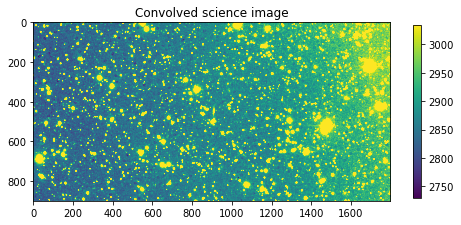

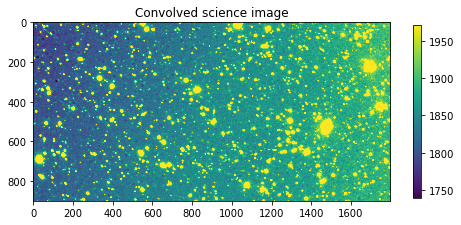

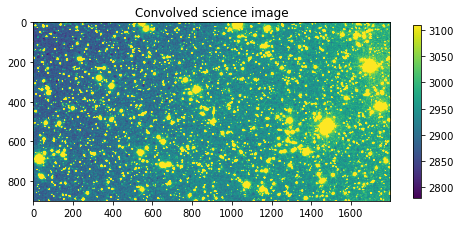

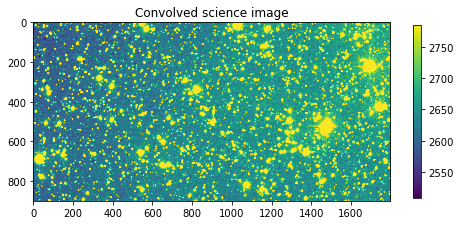

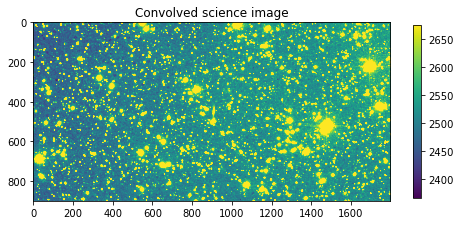

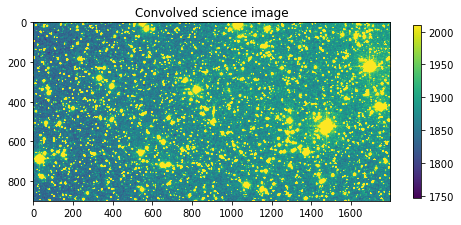

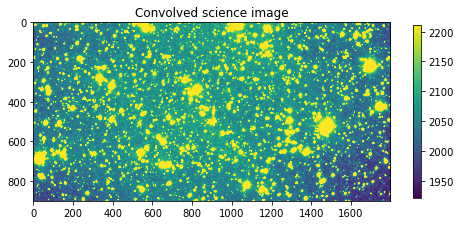

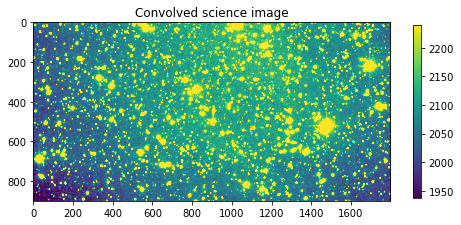

In [27]:
for i in range(len(align_image_array)):
    image = fits.open(align_image_array[i])
    mean, median, std = sigma_clipped_stats(image[0].data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    # Name looks totally wrong!
    plt.imshow(image[0].data, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved science image')
    plt.show()



# Background Subtraction
- Mask sources in images
- Use 3 sigma clipping to filter data and accurately measure the backgorund
- Then split image into 300x300 pixel boxes and apply 2x2 median filter

That was the original. We are going to (for the first image)

1) look at the scalar background (for no good reason!)
2) look at the 2D background with no mask
3) look at the 2D background a mask

And then assume (3) is best and go ahead with subtracting them all!

In [28]:
# Let's loop through the images and check the essential statistics on each background.

sigma_clip = SigmaClip(sigma=3.0, maxiters=20) # parameters for estimation
footprint = circular_footprint(radius=10) #size of source subtraction?
print("Mean, Median, and Standard Deviation for the background in each image\n\n")
for i in range(len(align_image_array)):
    image = fits.open(align_image_array[i])
    # Eventually do this for each image in the array.
    #image = sci_image_aligned # remove for multi image!
    #image = fits.open(align_image_array[0])
    hdr = image[0].header #save fits header
    threshold = detect_threshold(image[0].data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(image[0].data, threshold, npixels=10)
    
    # This next line fails sometimes, so let's put in some debugging
    #plt.imshow(segment_img, origin='lower', cmap=segment_img.cmap,interpolation='nearest')
    #plt.colorbar()
    #plt.show()
    
    mask = segment_img.make_source_mask(footprint=footprint)
    mean, median, std = sigma_clipped_stats(image[0].data, sigma=3.0, mask=mask)
    print((mean, median, std))  

Mean, Median, and Standard Deviation for the background in each image


(2867.3906, 2865.7317, 67.2701)
(1844.9778, 1845.7493, 54.094368)
(2926.9993, 2927.3164, 73.81018)
(2633.8445, 2633.4321, 62.122723)
(2506.9448, 2506.4932, 70.17081)
(1867.8466, 1867.1028, 59.26666)
(2048.1543, 2048.3306, 61.151844)
(2069.5327, 2070.0037, 67.72179)


I guess just look for outliers....

2D background estimator (50x50 box, 3x3 median filter). First image first.

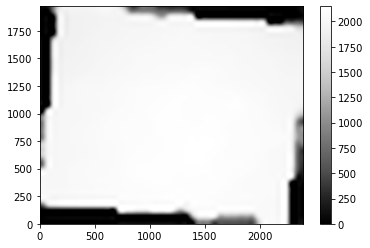

In [11]:
bkg_estimator = MedianBackground()
sigma_clip = SigmaClip(sigma=3.0)
bkg = Background2D(image[0].data, (bg_size,bg_size), filter_size=(filter_size, filter_size),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

But this is unmasked, and it does look like the stars are impacting the background. So let's try the same with a mask.

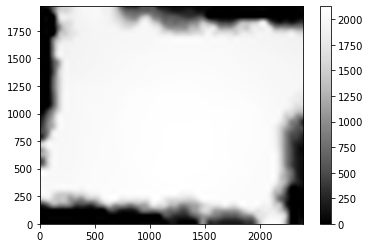

In [12]:
bkg = Background2D(image[0].data, (bg_size,bg_size), filter_size=(filter_size, filter_size),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

yyyeaahh I guess that's better, the background should probably be NOT bumpy at all. So use this and background subtract everything.

(Background goes negative here, I had real problems in AIJ with that....)

In [14]:
# Do this for each image in the array.
bkg_subtract_array=[]
for i in range(len(align_image_array)):
    image = fits.open(align_image_array[i])
    hdr = image[0].header #save fits header
    
    # get source mask individually for each image (why do we have to do this now?)
    threshold = detect_threshold(image[0].data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(image[0].data, threshold, npixels=10)
    mask = segment_img.make_source_mask(footprint=footprint)
    
    # measure and subtract the background
    bkg = Background2D(image[0].data, (bg_size,bg_size), filter_size=(filter_size,filter_size),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
    bkg_subtract_name=align_image_array[i].replace(".resamp.fits", "_bkgsub.fits")
    bkg_subtract_array.append(bkg_subtract_name)
    image[0].data = image[0].data - bkg.background
    hdu_image_sub = fits.PrimaryHDU(image[0].data,image[0].header) #added headers!
    hdu_image_sub.writeto(bkg_subtract_name,overwrite=True)
    
    print("Writing background subtracted file",bkg_subtract_name)

Writing background subtracted file SUM_Aligned_20230308_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20230309_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20230310_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20230311_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20230312_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20230313_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20240116_I_Rotated_bkgsub.fits
Writing background subtracted file SUM_Aligned_20240119_I_Rotated_bkgsub.fits


These images look right in AIJ, but I did get an error that these images are now double precision, whereas AIJ expects single precision. Fine for now?

In [15]:
bkg_subtract_array

['SUM_Aligned_20230308_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230309_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20240116_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20240119_I_Rotated_bkgsub.fits']

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on the reference image (which we assume to be the last in the list).  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science (reference?) frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  


In [16]:
# use REFERENCE image to extract sources.
# overwriting the catalog, but I guess that doesn't matter much.

#ref_image_bkgsub_name = ref_bkg_subtract_name # SWTICH when you go back to multi image!
ref_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[len(bkg_subtract_array)-1])

if os.path.exists('prepsfex.cat'): #Remove possible temporary files
    os.remove("prepsfex.cat") 

try:
    #command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    #command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (ref_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20240119_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Now we use another software part of the AstrOmatic suite, PSFex, to **measure the PSF of the reference image**. PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



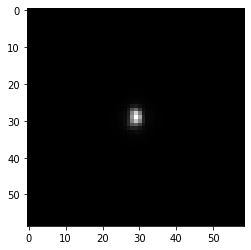

In [17]:
# Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
if not os.path.isdir('out'): os.mkdir('out')

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    #command = "psfex %s -c %s" % (source_extract_cat_name,psfex_config_name)
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_ref_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # temporary name?
print(psf_ref_image_name)
psf_ref_image = fits.open(psf_ref_image_name)

plt.imshow(psf_ref_image[0].data[0], cmap='gray')

mostly round ball...as expected...

### Convolve the reference image with the PSF of each science image

Now that the kernel is generated, let's convolve the reference image with the PSF of each science frame, to create our array of convolved science images.

In [18]:
#sci_bkg_subtract = fits.open(bkg_subtract_array[2])
#sci_bkg_subtract[0].header

header is almost empty - in particular it's missing the WCS! (old comment?)

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230308_I_Rotated_bkgsub_conv.fits


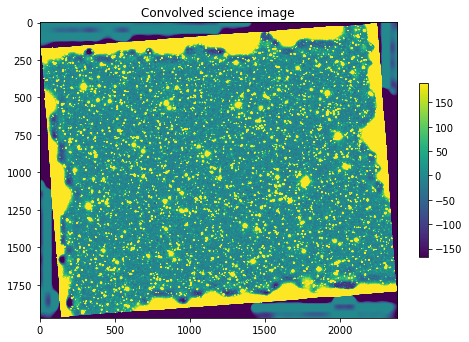

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230309_I_Rotated_bkgsub_conv.fits


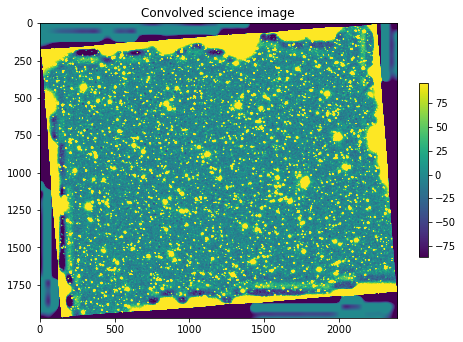

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230310_I_Rotated_bkgsub_conv.fits


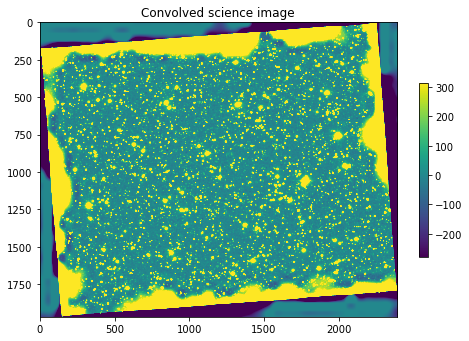

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230311_I_Rotated_bkgsub_conv.fits


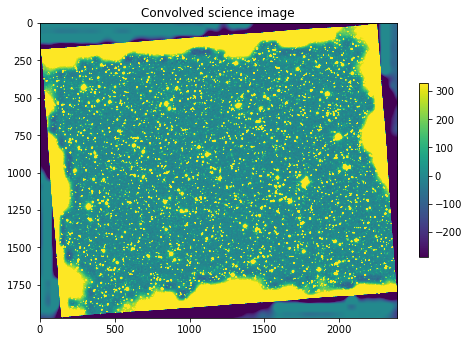

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230312_I_Rotated_bkgsub_conv.fits


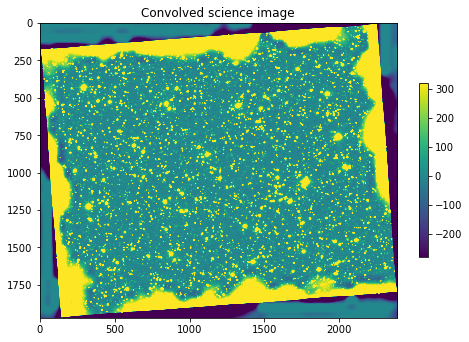

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230313_I_Rotated_bkgsub_conv.fits


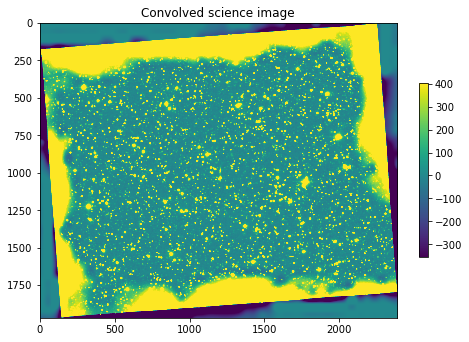

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20240116_I_Rotated_bkgsub_conv.fits


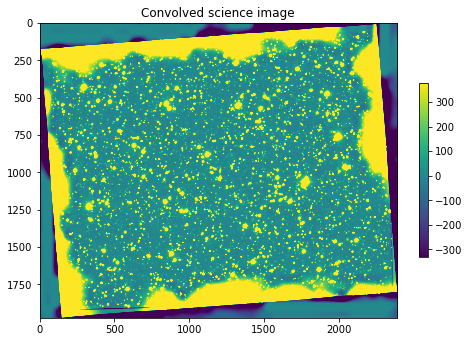

In [19]:
# Convolve the kernel of the reference image with the PSF of each science frame
kernel_ref = psf_ref_image[0].data[0]

# for plotting
#fig, axes = plt.subplots(3, math.ceil(len(bkg_subtract_array)/3.))
#plt.figure(figsize=(4,4))

sci_conv_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's reference
    sci_bkg_subtract = fits.open(bkg_subtract_array[i])
    sci_conv = scipy_convolve(sci_bkg_subtract[0].data, kernel_ref, mode='same', method='fft') # convolve step
    hdu_sci_conv = fits.PrimaryHDU(sci_conv,sci_bkg_subtract[0].header) # really should be adding header keys!
    sci_conv_array.append(bkg_subtract_array[i].replace(".fits","_conv.fits"))
    sci_conv_name=os.path.join(proc_dir,sci_conv_array[i])
    
    # Write the images
    print(sci_conv_name)
    hdu_sci_conv.writeto(sci_conv_name,overwrite=True)

    #Plot up the convolved reference image
    mean, median, std = sigma_clipped_stats(hdu_sci_conv.data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    # Name looks totally wrong!
    plt.imshow(sci_bkg_subtract[0].data, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved science image')
    plt.show()

Kinda hard to tell they are changing, but I think they are!

Next step is actually to create a refernce image for each science image, which is the reference convolved with the science. Then each pair should have the same PSF.

In [20]:
sci_conv_array


['SUM_Aligned_20230308_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230309_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20240116_I_Rotated_bkgsub_conv.fits']

### Convolve the science image with the PSF of the reference image


Same as above, but this time we generate a kernel with the properties of the **PSF of the science images**.  Then, we convolve the reference image with this kernel, once for each science image. This creates the array of convolved reference images, which are needed to subtract from the science frames.

I think what is happening here is the PSF data is stored in prepsfex.cat, as an output catalog from source-extractor, so we need to re-run the source extractor to get the PSF of the image in question.

Kernel from *each* science image

Image info:
Filename: SUM_Aligned_20230308_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2382, 1970)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230308_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



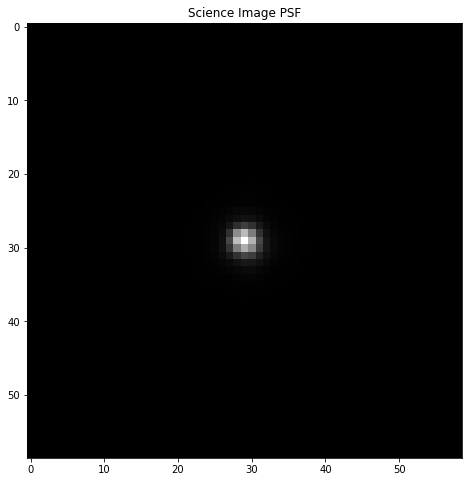

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230308_I_Rotated_bkgsub_refconv.fits


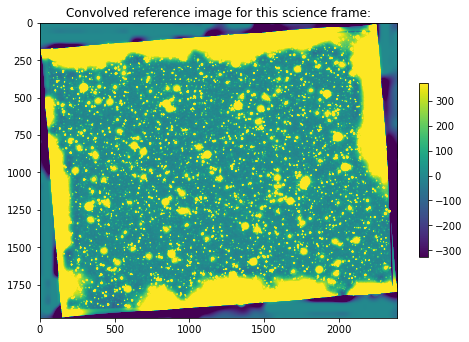

Image info:
Filename: SUM_Aligned_20230309_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2388, 1971)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230309_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



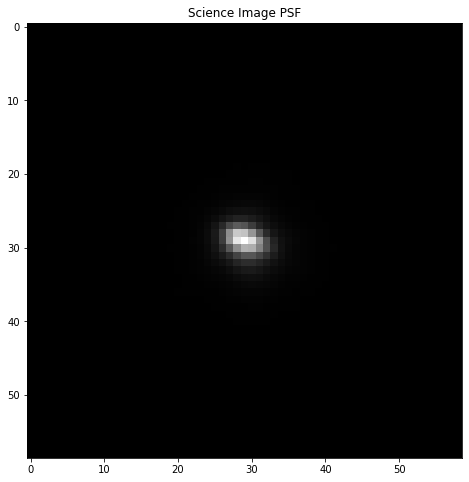

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230309_I_Rotated_bkgsub_refconv.fits


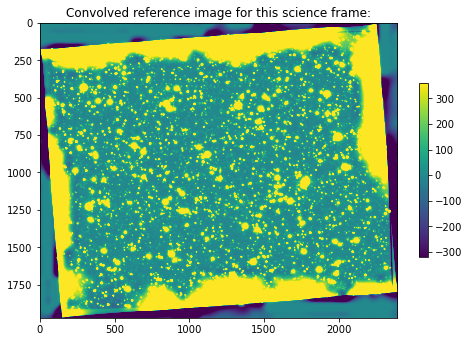

Image info:
Filename: SUM_Aligned_20230310_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2389, 1970)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230310_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



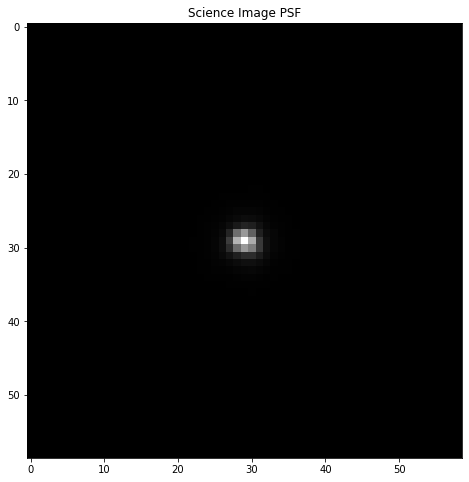

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230310_I_Rotated_bkgsub_refconv.fits


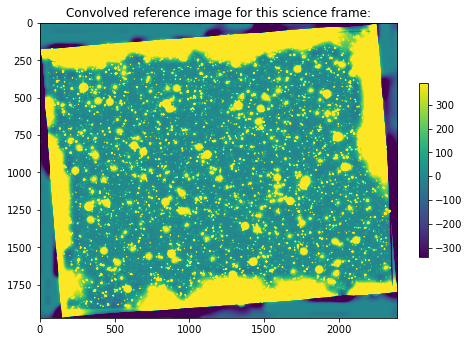

Image info:
Filename: SUM_Aligned_20230311_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2385, 1970)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230311_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



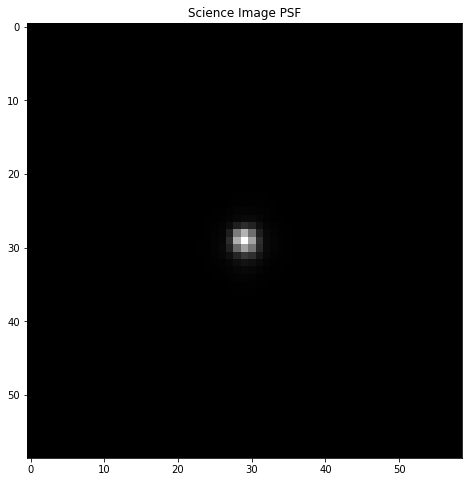

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230311_I_Rotated_bkgsub_refconv.fits


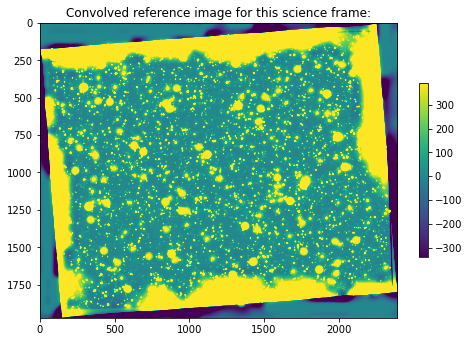

Image info:
Filename: SUM_Aligned_20230312_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2385, 1970)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230312_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



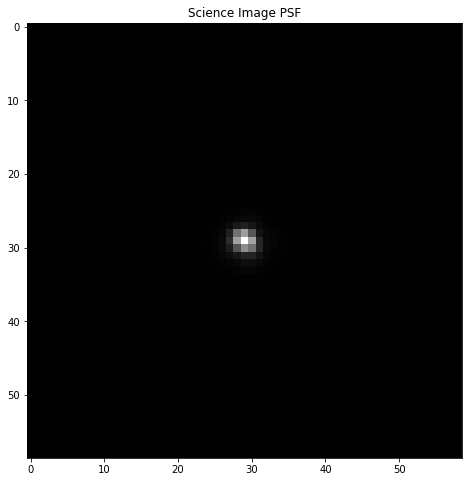

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230312_I_Rotated_bkgsub_refconv.fits


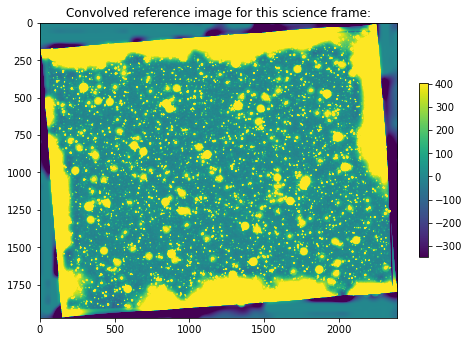

Image info:
Filename: SUM_Aligned_20230313_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2384, 1969)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230313_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



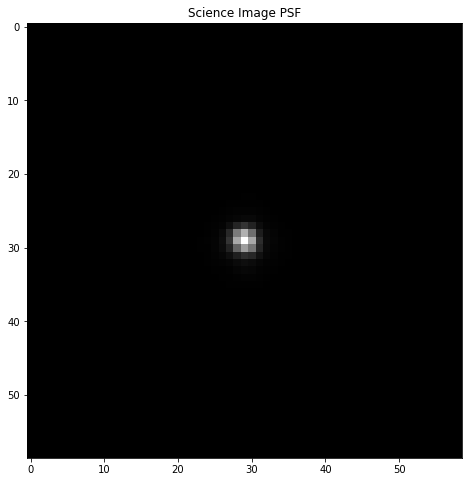

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230313_I_Rotated_bkgsub_refconv.fits


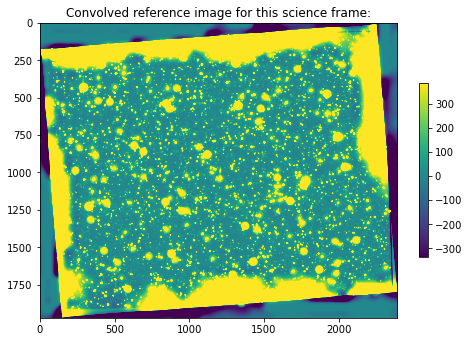

Image info:
Filename: SUM_Aligned_20240116_I_Rotated_bkgsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (2390, 1974)   float64   
Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20240116_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



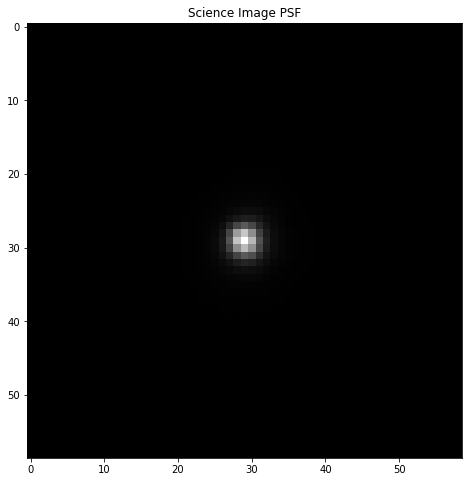

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/image_subtraction/processed/SUM_Aligned_20240116_I_Rotated_bkgsub_refconv.fits


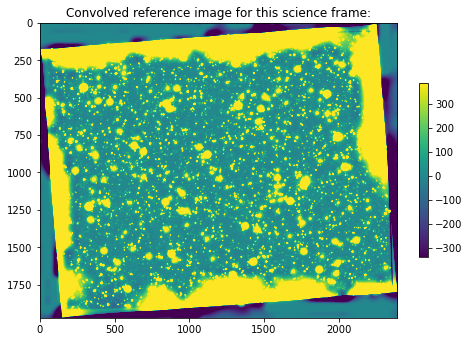

In [21]:
ref_conv_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's the reference
    sci_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[i])
    sci_bkg_subtract = fits.open(bkg_subtract_array[i]) # only need open to read the header
    print("Image info:")
    sci_bkg_subtract.info()
    try:
        command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)
     
    # Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
    if not os.path.isdir('out'): os.mkdir('out') # should be made already

    try:
        command = "psfex prepsfex.cat -c psfex_conf.psfex"
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run psfex with exit error %s'%err)

    psf_sci_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # DEFAULT name
    #psf_sci_image_name = os.path.join(out_dir,bkg_subtract_array[i].replace('.fits','_protoPSF.fits')) # rewriting each time!
    print(psf_sci_image_name)
    psf_sci_image = fits.open(psf_sci_image_name)
    # only the last image shows...
    plt.figure(figsize=(8,8))
    plt.imshow(psf_sci_image[0].data[0], cmap='gray')       
    plt.title('Science Image PSF')
    plt.show()   
        
    # Convolve the reference image with the PSF of each science frame
    # Grab the kernel!
    kernel_sci = psf_sci_image[0].data[0]
    
    # careful naming scheme needed!
    ref_bkg_subtract = fits.open(bkg_subtract_array[len(bkg_subtract_array)-1]) # REFERENCE IS LAST IMAGE!
    ref_conv = scipy_convolve(ref_bkg_subtract[0].data, kernel_sci, mode='same', method='fft') # convolve step
    hdu_ref_conv = fits.PrimaryHDU(ref_conv,ref_bkg_subtract[0].header) # header keys don't super matter...but from the reference!
    
    # yikes, this has to be named CAREFULLY!
    ref_conv_array.append(bkg_subtract_array[i].replace(".fits","_refconv.fits"))
    ref_conv_name=os.path.join(proc_dir,ref_conv_array[i])
    
    # Create the images
    print(ref_conv_name)
    hdu_ref_conv.writeto(ref_conv_name,overwrite=True)

    #Plot up the convolved reference image
    mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    plt.imshow(ref_conv, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved reference image for this science frame:')
    plt.show()    

Checking in AIJ, the resulting images have nearly the same PSF! (checking a few example sources, and they even seem to have the same pixel location values, which is good for us!

bright stars do have halos, which might be screwing up the background calculation, or the PSF? If we are eventually going to just subtract a circle, this might not matter.

In [22]:
ref_conv_array

['SUM_Aligned_20230308_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230309_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20240116_I_Rotated_bkgsub_refconv.fits']

### Improving the alignment
Now that the science image is convolved with (an approximation of) the PSF of the reference image, 
and the reference image is convolved with the PSF of the science image, we can perform the image subtraction.

- Before the subtraction we use an fft method (chi_2_shift) to fine-tune the image alignment of the reference and science image. We'll do this in pairs, reference aligning with science. When we go do photometry with AIJ, this fine tuning doesn't matter so much.

## Normalization of the images

The science and reference images are usually obtained with different exposure times.  In addition, the reference image can be the stack of several images to increase the depth.  Finally, different CCDs of the same camera (or even different regions of the same CCD when multiple amplifiers are present) may have slightly different gain. <br >

The background subtraction should have removed the non-linear offsets between science and reference images.  We can therefore normalize the two images by computing the ratio of bright star fluxes in the two images. Once again, we use SExtractor to extract the flux and other quantities.

We should be able to do this pairwise as well, as the offsets between different science images should be taken care of with our differential photometry. So we'll maybe normalize the reference(s) to the science?

In [23]:
sub_array=[]
#for i in range(len(bkg_subtract_array)-1): 
for i in range(len(sci_conv_array)): # changed this line!
    
    # Run SExtractor on the science image
    sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (sci_conv_array[i])

    try:
        command = sextractor_command
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)

    cat_sci = ascii.read('sci_match.cat') # dummy, should be able to rewrite constantly
    
    # Run SExtractor on the reference image
    sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (ref_conv_array[i])

    try:
        command = sextractor_command
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)

    # Read in the SExtractor output catalog
    cat_ref = ascii.read('ref_match.cat')
    
    # Match the catalog of sources of the reference and science images.  
    # Calculate the ratio between the flux of source in the science image over the flux of sources 
    # in the reference image.
    
    c_sci = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
    c_ref = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

    idx, d2d, d3d = c_sci.match_to_catalog_3d(c_ref)

    # Initialize a list for the indexes and one for the flux ratios
    # for each (sci, ref) pair, don't need to save all this?
    index_arr = []
    ratio_arr = []

    # Sure don't need to be printing all this stuff! Is there a final normalization i can use for checking?
    for j, i2, d in zip(idx, np.arange(len(d2d)),d2d):
        #print(i,d)
        #index_arr.append(i)
        #print("Image coordinates")
        #print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
        #print('Fluxes and flux ratio')
        #print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2], cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])
        ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][j]) # Ratio of SCI/REF!
    
    scale = np.median(ratio_arr)
    print("The scaling factor is", scale)
    
    # fine tune the alignment here - at least without this, the alginment is terrible!
    sci_image = fits.open(sci_conv_array[i])
    ref_image = fits.open(ref_conv_array[i])
    xoff, yoff, exoff, eyoff = chi2_shift(ref_image[0].data, sci_image[0].data, 10, return_error=True, upsample_factor='auto')
    print("Alignment offsets:",xoff,yoff)
    sci_image_shift = scipy.ndimage.shift(sci_image[0].data, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)
 
    # Create an empty image with the reference image in a square in the center.
    #RA=128.249
    #Dec=-27.449311
    coord = SkyCoord(RA,Dec,unit='deg')
    w = WCS(sci_image[0].header)
    x, y = w.world_to_pixel(coord)
    print("The center of the image is at: ",x,y)

    synthetic_image=np.zeros(sci_image[0].data.shape)
    synthetic_image[int(y)-window:int(y)+window,int(x)-window:int(x)+window]=ref_image[0].data[int(y)-window:int(y)+window,int(x)-window:int(x)+window]


    # Rescale the reference image to the science and perform the image subtraction.
    #image_sub = sci_image_shift-ref_image[0].data*scale
    image_sub=sci_image_shift-synthetic_image*scale
    hdu_image_sub = fits.PrimaryHDU(image_sub,sci_image[0].header) # header might need work!
    sub_array.append(sci_conv_array[i].replace(".fits","_diff.fits")) 
    hdu_image_sub.writeto("out/"+sub_array[i],overwrite=True) # move to the out directory


Executing command: source-extractor SUM_Aligned_20230308_I_Rotated_bkgsub_conv.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!
Executing command: source-extractor SUM_Aligned_20230308_I_Rotated_bkgsub_refconv.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!


/tmp/ipykernel_62139/4123143274.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][j]) # Ratio of SCI/REF!
/tmp/ipykernel_62139/4123143274.py:54: RuntimeWarning: invalid value encountered in scalar divide
  ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][j]) # Ratio of SCI/REF!


The scaling factor is nan


ValueError: Images must have same shape.

Let's plot them all to get a good look.

In [ ]:
fig, axs = plt.subplots(len(sci_conv_array), 2,figsize=(50,50))
for i in range(len(sci_conv_array)):
    sci_image = fits.open(sci_conv_array[i])
    sub_image = fits.open("out/"+sub_array[i])
    
    mean, median, std = sigma_clipped_stats(sub_image[0].data)
    axs[i,0].imshow(sub_image[0].data[600:1200,600:1200], vmin=median-2*std, vmax=median+2*std, cmap='gray')
        
    mean, median, std = sigma_clipped_stats(sci_image[0].data)
    axs[i,1].imshow(sci_image[0].data[600:1200,600:1200], vmin=median-2*std, vmax=median+2*std, cmap='gray')

 Well the galaxy seems to have disappeared, but the PSF matching certainly does not look great. 
 
 Actually, on the first test these things actually produce what looks like a SN, even without the cutout. However, let's put the cutout in!